## Import Libraries

In [15]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os.path
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score


In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [19]:
!kaggle datasets download -d grassknoted/asl-alphabet

100% 1.03G/1.03G [00:09<00:00, 148MB/s]



In [23]:
!ls

asl-alphabet.zip  model_large_asl_mobilenet-1.h5  WIN_20210704_17_47_10_Pro.jpg
gdrive		  sample_data


In [24]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

**Function to build the train and test df**

In [25]:
def imgPaths(filepath):

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

## Build Train and Test Data Frame

In [26]:
# Create Variables
train_image_dir = Path('/content/asl_alphabet_train')
train_filepaths = list(train_image_dir.glob(r'**/*.jpg'))

test_image_dir = Path('/content/asl_alphabet_test')
test_filepaths = list(train_image_dir.glob(r'**/*.jpg'))

# Create df
train_df = imgPaths(train_filepaths)
test_df = imgPaths(test_filepaths)

# Show the result
print(train_df.head(3))
print(test_df.head(3))

                                            Filepath Label
0  /content/asl_alphabet_train/asl_alphabet_train...     N
1  /content/asl_alphabet_train/asl_alphabet_train...     K
2  /content/asl_alphabet_train/asl_alphabet_train...   del
                                            Filepath  Label
0  /content/asl_alphabet_train/asl_alphabet_train...      R
1  /content/asl_alphabet_train/asl_alphabet_train...      Z
2  /content/asl_alphabet_train/asl_alphabet_train...  space


In [27]:

print(f'Number of pictures: {train_df.shape[0]}\n')

print(f'Number of different labels: {len(train_df.Label.unique())}\n')

print(f'Labels: {train_df.Label.unique()}')


# Create a DataFrame with one Label of each category
# drops dups of columns
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

Number of pictures: 87000

Number of different labels: 29

Labels: ['N' 'K' 'del' 'Q' 'O' 'F' 'D' 'G' 'nothing' 'Y' 'T' 'S' 'P' 'Z' 'B' 'U'
 'H' 'V' 'W' 'R' 'X' 'I' 'A' 'L' 'E' 'space' 'M' 'J' 'C']


## Display Images

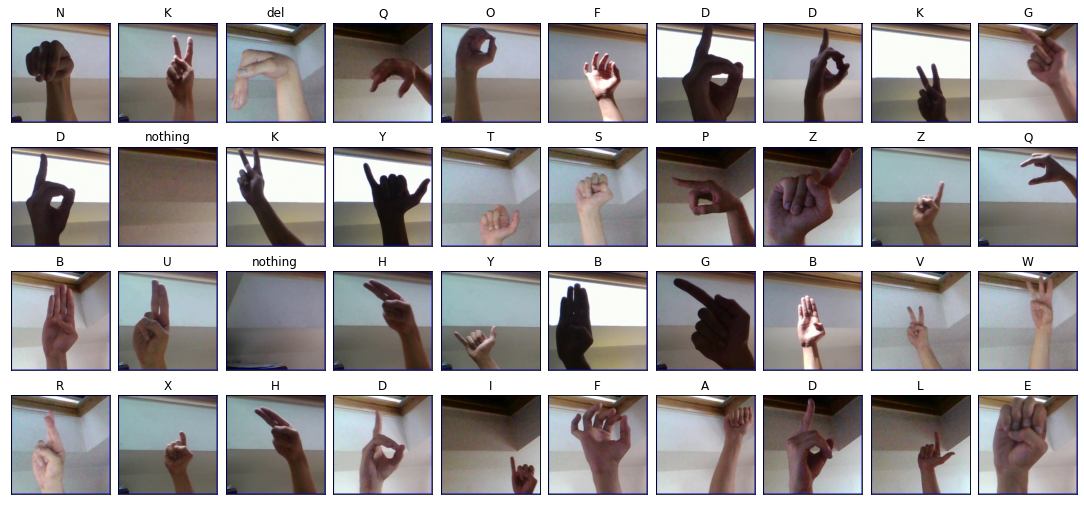

In [28]:
# Display 40 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]))
    ax.set_title(train_df.Label[i])
plt.tight_layout(pad=.5)
plt.show()

## Train Feature Extraction and ImageGenerator

In [43]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2, rotation_range = 30 , fill_mode = 'nearest' , zoom_range = 0.2 , shear_range = 0.2 , width_shift_range=0.1, height_shift_range=0.1,
    brightness_range = [0.2,1.0]
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [44]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training',
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 69600 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.
Found 87000 validated image filenames belonging to 29 classes.


## Import Pretrained MobileNet V2 Model

In [48]:
# Load the pretained model
pretrainedModel = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel.trainable = False



## Fit Data to the Model

In [51]:
inputs = pretrainedModel.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

#adam = tf.keras.optimizers.Adam(
#    learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#    name='Adam'
#)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=3,
    callbacks=[
         tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
     ]
 )

Epoch 1/3
2175/2175 [==============================] - 1027s 471ms/step - loss: 0.6164 - accuracy: 0.8106 - val_loss: 0.3595 - val_accuracy: 0.8790
Epoch 2/3
2175/2175 [==============================] - 1016s 467ms/step - loss: 0.3150 - accuracy: 0.8964 - val_loss: 0.2615 - val_accuracy: 0.9123
Epoch 3/3
2175/2175 [==============================] - 1017s 468ms/step - loss: 0.2605 - accuracy: 0.9140 - val_loss: 0.2305 - val_accuracy: 0.9232


## Visualize the Results

In [53]:
model.save('model_large_asl_mobilenet-v1.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [54]:
# Evaluate
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.13624
Test Accuracy: 95.39%


**Predict**

In [55]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['R', 'Z', 'space', 'S', 'P']


**Accuracy**

In [56]:
from sklearn.metrics import accuracy_score
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 95.39%


**Classification Report**

In [57]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           A       0.96      0.98      0.97      3000
           B       1.00      0.95      0.97      3000
           C       1.00      0.99      0.99      3000
           D       0.95      0.99      0.97      3000
           E       0.96      0.95      0.95      3000
           F       1.00      0.97      0.98      3000
           G       0.96      0.98      0.97      3000
           H       0.99      0.95      0.97      3000
           I       0.92      0.98      0.95      3000
           J       0.98      0.92      0.95      3000
           K       0.94      0.98      0.96      3000
           L       0.97      0.99      0.98      3000
           M       0.98      0.93      0.96      3000
           N       0.94      0.98      0.96      3000
           O       0.96      0.97      0.97      3000
           P       0.98      0.98      0.98      3000
           Q       1.00      0.92      0.95      3000
           R       0.97    

**Display 50 images with predict and validation**

In [58]:
# Display the result of prediction from before
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['R', 'Z', 'space', 'S', 'P']


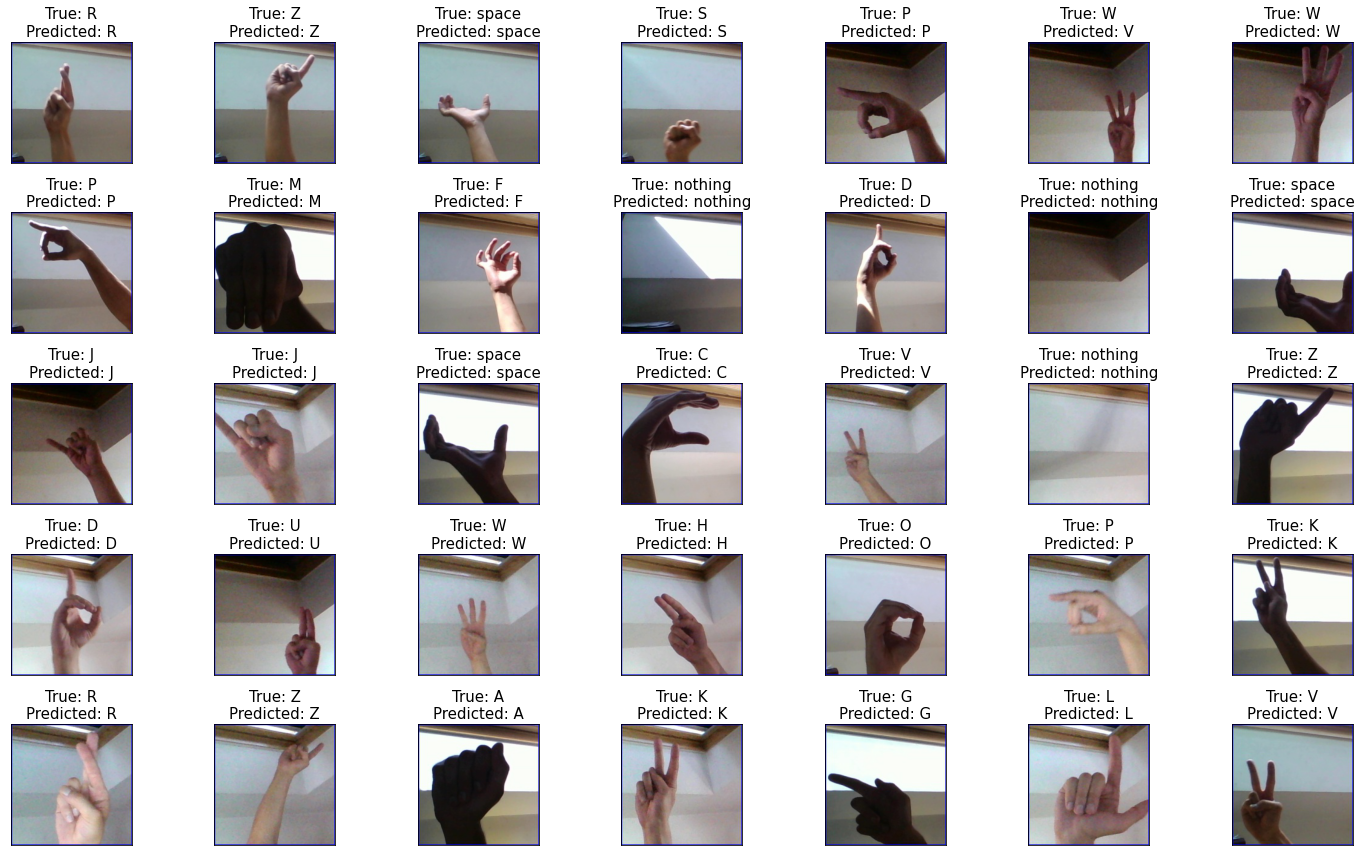

In [59]:
# Display 50 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

## Testing

In [60]:
#from tensorflow import keras
#model = keras.models.load_model('/content/model_large_asl_mobilenet-1.h5')

In [260]:
import cv2 
import numpy as np 
from keras.applications.mobilenet_v2 import preprocess_input
from skimage.transform import resize

In [278]:
test_img = cv2.imread('/content/WIN_20210704_22_28_08_Pro.jpg')
test_img = preprocess_input(test_img)
test_img = resize(test_img, (224,224,3))
test_img = np.array(test_img , dtype='float32') 
test_img = test_img.reshape(1,224,224,3)
print(test_img.shape) 

(1, 224, 224, 3)


In [279]:
prediction = model.predict(test_img)
prediction = np.argmax(prediction,axis=1)
prediction


array([24])

In [282]:
labels[24]

'Y'

In [281]:
labels

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z',
 26: 'del',
 27: 'nothing',
 28: 'space'}

## References 


https://www.kaggle.com/grassknoted/asl-alphabet  

